# Multiclass Logistic Regression:

In the previous chapter, we introduced logistic regression, a classic algorithm for performing binary classification. We implemented the model:
$$
    \bar y = \sigma (xw^T + b), where\; \sigma \; is\;the\;sigmoid\;squashing\;function
$$

This activation function on the final layer was crucial because it forced our outputs to take values in the range $[0, 1]$. That allowed us to interpret these outputs as probabilities. We then updated our parameters to give the true labels (which take values either 1 or 0) the highest probability.

Binary classification is quite useful. We can use it to predict spam vs. not spam or cancer vs not cancer. But not every problem fits the mold of binary classification. Sometimes we encounter a problem where each example could belong to one of $k$ classes. 
Given $k$ classes, the most naive way to solve a multiclass classification problem is to train $k$ different binary classifiers $f_i(x)$.
We could then predict that an example $x$ belongs to the class $i$ for which the probability that the label applies is the highest: 
$$
\underset{i}{max}\;f_i(x)
$$

The smarter way to go about this is to force the output layer to be a discrete probability distribution over $k$ classes.
To be a valid probability distribution we would want the output $\bar y$ to:
1. Contain only non- negative values.
2. Sum to 1.
    
We accomplish this by using the <I><b>softmax</b></I> function. Given an input vector $z$, softmax does two things. First, it exponentiates (elementwise) $e^z$, forcing all the values to be strictly positive. Then it normalizes so that all values sum to 1. Following the softmax operation computes the following:
$$
    softmax(z) = \frac{e^z}{\sum_{i=1}^k e^{z_i}}
$$

We'll need weights to connect each of our inputs to each of our k outputs.
The weights can be represented one for each input and output node pair in a matrix $W$.
We generate the linear mapping from inputs to outputs via matrix-vector product $xW + b$.
Note that bias term ($b$) is now a vector, with one component for each output node.
The multiclass classification model can be written as:
$$
    \bar y = softmax(xW + b)
$$

This model is sometimes called the <I> multiclass logistic regression</I>. Other names for it include <I>softmax regression</I> and <I> multinomila regression</I>. For these concepts to sink in lets actually implement softmax regression. We will be using the multiclass classification model to classify hand-written digits this time.

Note:
In mathematical notation we represent vectors with lower case alphabets and matrices with upper case alphabets.

### Batch Training:

Let's assume we have $d$ inputs and $k$ outputs. So the shapes of various variables explicitly would be:
$$
    \underset {1\times k}{z} = \underset {1\times d}{x} \cdot \underset{d \times k} {W} + \underset{1 \times k} {b}
$$
    
We will be one hot encoding our output labels, for example $\bar y = 5$ would be $\bar y_{one-hot} = [0,0,0,0,1,0,0,0,0,0]$ when one-hot encoded for a 10-class classification problem.
    
So $\bar y = softmax(z)$ becomes:
$$
   \underset {1\times k}{\bar y_{one-hot}} = softmax_{one-hot}(\underset {1\times k} {z})
$$
    
Suppose if we input a batch of m training examples, we would have a matrix $\underset {m \times d}{X}$ that is vertical stacking of individual training examples $x_i$.

$$
    X = \left[ \begin{matrix}
                x_1\\
                x_2\\
                \vdots \\
                x_m
               \end{matrix}
         \right]
      = \left[ \begin{matrix}
                  x_{11} & x_{12} & \dots & x_{1d}\\
                  x_{21} & x_{22} & \dots & x_{2d}\\
                  \vdots & \vdots & \ddots & \vdots\\
                  x_{m1} & x_{m2} & \dots & x_{md}
                \end{matrix}
        \right]
$$

Under this batch training situation, $\bar y_{one-hot} = softmax(z)$ turns into:
$$
    Y = softmax(Z) = softmax(XW + B)
$$
    
where matrix $\underset {m \times k}{B}$ is formed by having $m$ copies of $b$ as follows:
$$
    B = \left[ \begin{matrix}
                    b\\
                    b\\
                    \vdots \\
                    b
                \end{matrix}
         \right]
      = \left[ \begin{matrix}
                  b_1 & b_2 & \dots & b_k\\
                  b_1 & b_2 & \dots & b_k\\
                  \vdots & \vdots & \ddots & \vdots\\
                  b_1 & b_2 & \dots & b_k
                \end{matrix}
         \right]
$$

Each row of matrix $ \underset {m \times k}{Z}$ corresponds to one training example. The softmax function operates on each row of matrix $Z$ and returns a matrix $\underset {m \times k}{Y}$, each row of which corresponds to the one-hot encoded prediction of one training example.

In [2]:
#importing the libraries
from __future__ import print_function
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon
mx.random.seed(1)

In [3]:
#setting the compute context using MXNet
#Feel free to change model_ctx to mx.gpu() if you have a well endowed machine
data_ctx = mx.cpu()
model_ctx = mx.cpu()
#model_ctx = mx.gpu()

We are going to work with 28*28 centrally cropped black and white photograph of a hand-written digit.
We'll use MXNet's utility to grab a copy of the dataset.
The datasets accept a transform callback that can preprocess each item.
Cast data and label to floats and normalize data to range $[0,1]$.
We'll be using the test data for determining the accuracy of the model.

In [4]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = gluon.data.vision.MNIST(train=1, transform = transform)
mnist_test = gluon.data.vision.MNIST(train=0, transform = transform)

There are 2 parts of dataset for train and test. Each part has N items and each item is a tuple of an image and label:

In [5]:
image, label = mnist_train[0]
print(image.shape, label)

(28, 28, 1) 5.0


Note that each image is formatted as a 3-tuple: (height, width, channel). For colored images, the channel would have 3 parameters: (Red, Green and Blue)

In [6]:
print(len(mnist_train))
print(28*28)

60000
784


In [7]:
num_inputs = 784
num_outputs = 10
num_examples = 60000

Machine learning libraries generally expect to get images in (batch, channel, height, width) format. However, most libraries for visualization prefer (height, width, channel). matplolib expects (height, width) or (height, width, channel) with RGB channels, so let's broadcast our single channel to 3.

In [8]:
im = mx.nd.tile(image, (1, 1, 3))
print(im.shape)

(28, 28, 3)


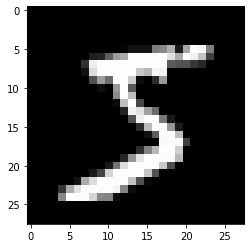

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(im.asnumpy())
plt.show()

In [10]:
#loading images into a data iterator
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle = 1)

In [11]:
#loading iterator for the test_data
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle = 0)

We will flatten each image into a single 1D vector with 28\*28 = 784 components
because our task is multiclass classification we will want to assign a probability to each of the classes $P(y = C|X)$ given the input $X$.
In order to do this we are going to need one vector of 784 weights for each class, connecting each feature to the corresponding output.
We'll also allocate one offset, called bias, for each of the outputs.

In [12]:
W = nd.random_normal(shape = (num_inputs, num_outputs), ctx = model_ctx)
b = nd.random_normal(shape = num_outputs, ctx = model_ctx)

params = [W,b]

In [13]:
#we need to let MXNet know we'll be expecting gradients corresponding to each of these parameters during training
for param in params:
    param.attach_grad()

We are going to linearly map our input $X$ onto 10 different real valued outputs `y_linear`.
Then, before outputting these values, we'll want to normalize them so that they are non-negative and sum to 1.
This normalization allows us to interpret the output $\bar y$ as valid probability distibution.

In [14]:
def softmax(y_linear):
    exp = nd.exp(y_linear - nd.max(y_linear, axis = 1).reshape((-1,1)))
    norms = nd.sum(exp, axis = 1).reshape((-1,1))
    return exp/norms

In [15]:
sample_y_linear = nd.random_normal(shape = (2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)


[[0.38854712 0.15868284 0.09794893 0.01202093 0.01595045 0.04553349
  0.14224595 0.0314311  0.04231628 0.06532289]
 [0.08514825 0.43826103 0.02771222 0.08836042 0.17408127 0.05132056
  0.02093019 0.06935012 0.03025253 0.01458343]]
<NDArray 2x10 @cpu(0)>


In [16]:
#confirming that the rows sum to 1
print(nd.sum(sample_yhat, axis = 1))


[1. 1.]
<NDArray 2 @cpu(0)>


In [17]:
def net(X):
    y_linear = nd.dot(X,W) + b
    yhat = softmax(y_linear)
    return yhat

### The cross-entropy loss Funtion:

The cost function being used here is called Cross Entropy:
The basic idea is that we are going to take a target $Y$ that has been formatted as a one-hot vector, meaning one value
corresponding to the correct label is set to 1 and others are set to 0, 
eg: $[0,1,0,0,0,0,0,0,0,0]$

The basic idea of cross entropy loss is that we only care about how much probability is assigned to the correct label.
In other words, we only care about the component of yhat assigned to label 2.
Cross-entropy attempts to maximize the log-likelihood given to the correct labels.

In [18]:
def cross_entropy(yhat, y):
    return -nd.sum(y * nd.log(yhat + 1e-6))

### Optimizer:

In [19]:
#We'll be using the stochastic gradient descent optimizer
def SGD(params, lr):
    for param in params:
        param[:] = param - lr*param.grad

### Evaluation loop to calculate accuracy:

Generally we define accuracy as the number of correct answers divided by the total number of questions.
Lets write an evaluation loop that will take a data iterator and a network, returning a model's accuracy averaged over the
entire dataset.

In [20]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0
    denominator = 0
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis = 1)
        numerator += nd.sum( predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [21]:
#Because we initialized our model randomly and roughly 1/10th of all examples belong to each of the 10 classes we should
#have an accuracy close to 0.10
evaluate_accuracy(test_data, net)

0.1167

### Training loop:

In [22]:
epochs = 5
learning_rate = 0.005

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape(-1,784)
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
        
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss 1.377373925558726, Train_acc 0.85815, Test_acc 0.8643
Epoch 1. Loss 0.6138278275171916, Train_acc 0.88275, Test_acc 0.8819
Epoch 2. Loss 0.518171291565895, Train_acc 0.89005, Test_acc 0.8865
Epoch 3. Loss 0.46832715154886245, Train_acc 0.8976, Test_acc 0.8931
Epoch 4. Loss 0.43529989680051806, Train_acc 0.9023833, Test_acc 0.9


### Using the model for prediction:

(10, 28, 28, 1)
(10, 28, 28, 1)


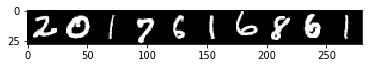

model predictions are: 
[2. 0. 1. 7. 6. 1. 6. 8. 6. 1.]
<NDArray 10 @cpu(0)>


In [23]:
#We'll pick 10 random data points from the test dataset and use the trained model for predictions
#Define the function to do prediction
def model_predict(net, data):
    output = net(data)
    return nd.argmax(output, axis = 1)

#sampling 10 data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle = 1)

for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data, (1,0,2,3))
    print(data.shape)
    im = nd.reshape(im, (28, 10*28, 1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred = model_predict(net, data.reshape((-1, 784)))
    print('model predictions are:', pred)
    break

### Conclusion:

We can get 90% accuracy at this task just by training a linear model for a few seconds!